In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt

import random

In [2]:
import Data
import Model
import Plot

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
l1 = torch.tensor(np.zeros(1,dtype=np.float32),dtype=torch.float32, device=device) 
l2 = torch.tensor(np.ones(1,dtype=np.float32),dtype=torch.float32, device=device)  

def Negatives_list(inx, num_clients):
    
    a = range(0, num_clients)
    f = lambda x : False if inx == x else True
    
    return list( filter(f, a) )

In [5]:
loss_history = []
num_clients = 8
samples = 10

biometrics = Data.Data_client(num_classes=num_clients, samples=samples, device=device)
client_loader = DataLoader(biometrics, batch_size=10, shuffle=True)

print(len(biometrics))

lr = 0.001
num_epoch = 200
Criterion = Model.ContrastiveLoss(margin=10.0)

client_models = Model.get_client_models(number=num_clients, device=device)

Optimizer = [torch.optim.SGD( client_models[i].parameters(), lr=lr) for i in range(0, num_clients) ]

10


In [6]:
for epoch in range(0, num_epoch):
    
    loss_per_client_per_epoch = np.zeros(shape=num_clients)
    
    for data in client_loader:
        
        losses = np.zeros(shape=num_clients)
        
        #forward pass through models
        out = [ client_models[i](data[i][0], data[i][1]) for i in range(0, num_clients) ]
        
        #updating the weights by computing loss for the models
        for i in range(0, num_clients):
            
            inx = random.choice(Negatives_list(i, num_clients))
            
            anc, pos = out[i]
            neg = out[inx][0]
            
            loss_positive = Criterion(anc,pos,l1)
            loss_negative = Criterion(anc,neg,l2)
            loss = loss_positive + loss_negative  #calculating the Contrastive loss for the current client model
            
            Optimizer[i].zero_grad()
            
            loss.backward(retain_graph=True)  #Graph needs to be retained to ensure other models can be updated
            losses[i] = loss.item()
            
            Optimizer[i].step()
            
        loss_per_client_per_epoch += losses
        
    print("epoch  : ",epoch,"\n\tmean loss : ",loss_per_client_per_epoch/samples)
    loss_history.append(loss_per_client_per_epoch/samples)
            

epoch  :  0 
	mean loss :  [9.70530853 9.90851212 9.84066391 9.82294769 9.90590515 9.64103012
 9.90872803 9.74457932]
epoch  :  1 
	mean loss :  [9.90323181 9.8008461  9.70188446 9.87251129 9.81466904 9.85015717
 9.88041382 9.66294937]
epoch  :  2 
	mean loss :  [9.54228592 9.86156464 9.66540222 9.66539154 9.7740242  9.42978821
 9.72256088 9.54959412]
epoch  :  3 
	mean loss :  [9.46035309 9.54363785 9.39157028 9.52230148 9.50338669 9.39156647
 9.7034874  9.43234329]
epoch  :  4 
	mean loss :  [9.34565353 9.5962204  9.50757828 9.7658577  9.37046814 9.74362793
 9.71212311 9.37047806]
epoch  :  5 
	mean loss :  [9.64089355 9.77266846 9.10620346 9.34226532 9.77266922 9.12100372
 9.69556046 9.53314056]
epoch  :  6 
	mean loss :  [9.20830536 9.35921707 9.60942535 9.52379684 9.54490433 9.78715515
 9.36292267 9.18819809]
epoch  :  7 
	mean loss :  [9.55336304 9.25154648 9.21540833 9.77380219 9.09968185 8.92539673
 9.40710602 8.92297745]
epoch  :  8 
	mean loss :  [8.83743057 9.51337128 9.3799

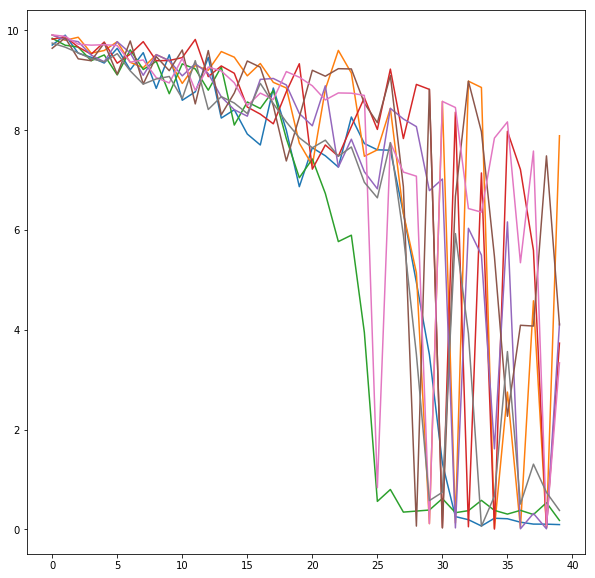

In [7]:
r = 40
loss_history = np.array(loss_history)

plt.figure(figsize=(10,10))
for i in range(0, num_clients):
    plt.plot( range(0, r), loss_history[:r,i])

In [8]:
plot_data = Data.Data_per_client(biometrics, client_models[6], num_clients)
plot_dataloader = DataLoader(plot_data, batch_size=10, shuffle=True)

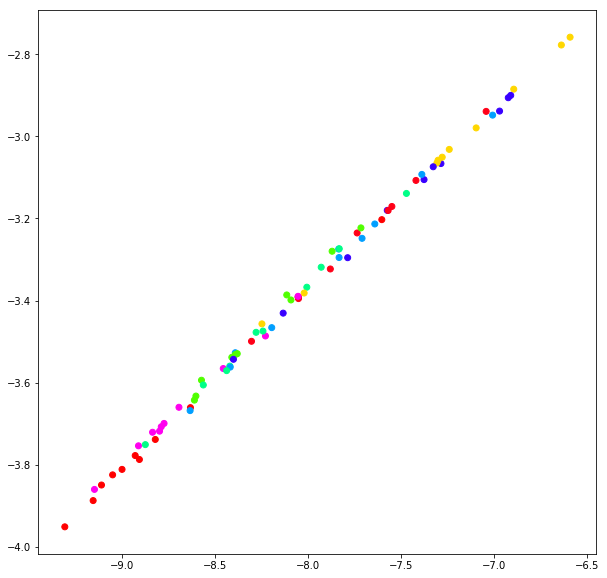

In [9]:
Plot.plot_data(num_clients, plot_dataloader, "hsv")

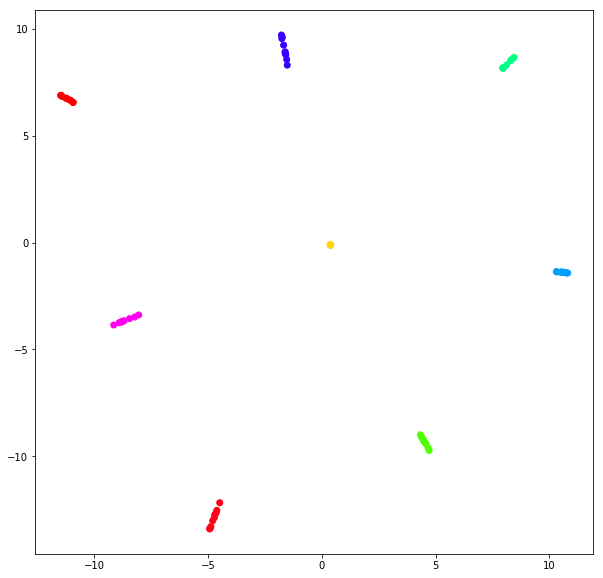

In [10]:
plot_data = Data.Data_server(biometrics, client_models)
plot_dataloader = DataLoader(plot_data, batch_size=10, shuffle=True)
Plot.plot_data(num_clients, plot_dataloader, "hsv")

In [11]:
loss_history = []
num_clients = 8
samples = 10

biometrics = Data.Data_client(num_classes=num_clients, samples=samples, device=device)
server_data = Data.Data_server(biometrics, client_models)
dataloader = DataLoader(server_data, batch_size=64, shuffle=True)

lr = 0.001
num_epoch = 200
Criterion = nn.CrossEntropyLoss()

model = Model.Discriminator(8).to(device)

Optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [12]:
loss_history = []

for epoch in range(0, num_epoch):
    
    losses = []
    
    for data in dataloader:
        
        vec, l = data
        out = model(vec)
        
        loss = Criterion(out, l.long())
        
        Optimizer.zero_grad()
        
        loss.backward()
        losses.append(loss.item())
        
        Optimizer.step()
    
    loss_history+=losses
    print("epoch : ", epoch, "\n\taverage loss : ", np.mean(losses))

epoch :  0 
	average loss :  2.129626989364624
epoch :  1 
	average loss :  2.1252321004867554
epoch :  2 
	average loss :  2.0847415924072266
epoch :  3 
	average loss :  2.0937682390213013
epoch :  4 
	average loss :  2.068295955657959
epoch :  5 
	average loss :  2.059987783432007
epoch :  6 
	average loss :  1.9948760271072388
epoch :  7 
	average loss :  2.0700080394744873
epoch :  8 
	average loss :  2.0203142166137695
epoch :  9 
	average loss :  2.0678338408470154
epoch :  10 
	average loss :  2.01920086145401
epoch :  11 
	average loss :  1.996449589729309
epoch :  12 
	average loss :  1.9964750409126282
epoch :  13 
	average loss :  2.0145307779312134
epoch :  14 
	average loss :  1.9729549884796143
epoch :  15 
	average loss :  1.9518620371818542
epoch :  16 
	average loss :  1.9365925788879395
epoch :  17 
	average loss :  1.9173732995986938
epoch :  18 
	average loss :  1.9347361326217651
epoch :  19 
	average loss :  1.9206103682518005
epoch :  20 
	average loss :  1.9654

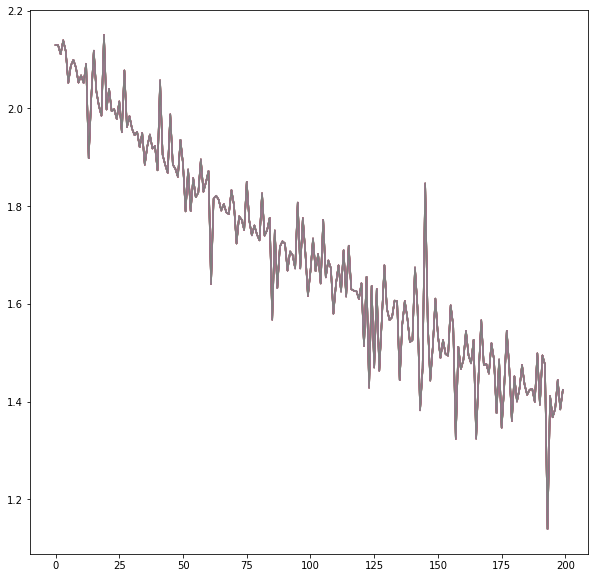

In [13]:
r = num_epoch
loss_history = np.array(loss_history)

plt.figure(figsize=(10,10))
for i in range(0, num_clients):
    plt.plot( range(0, r), loss_history[:r])

In [14]:
def test(model, dataloader):
    
    length = 0
    accuracy = 0

    
    for data in dataloader :
        
        img, lbl = data
        length+=len(lbl)    
        
        with torch.no_grad():

            preds = model(img)
            top_p, top_class = torch.topk(preds, 1, dim=1)
            accuracy += ( top_class == lbl.long().view(*top_class.shape) ).sum()
            
            
    accuracy = 100 * accuracy/length
   
    return accuracy

In [15]:
num_clients = 8
samples = 1000

biometrics = Data.Data_client(num_classes=num_clients, samples=samples, device=device)
server_data = Data.Data_server(biometrics, client_models)
dataloader = DataLoader(server_data, batch_size=1)

print("accuracy of the discriminator", test(model, dataloader).item(),"%")

accuracy of the discriminator 87 %


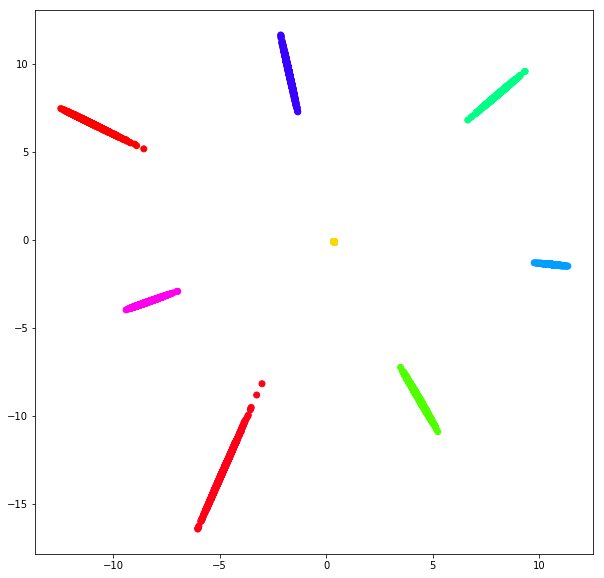

In [16]:
plot_dataloader = DataLoader(server_data, batch_size=10)
Plot.plot_data(num_clients, plot_dataloader, "hsv")

In [17]:
def test(model, dataloader):
    
    length = 0
    accuracy = 0

    data = []
    prediction = torch.empty(1).long().cuda()
    
    for data in dataloader :
        
        vec, lbl = data
        length+=len(lbl)    
        
        with torch.no_grad():

            preds = model(vec)
            top_p, top_class = torch.topk(preds, 1, dim=1)
            accuracy += ( top_class == lbl.long().view(*top_class.shape) ).sum()
            
            predicted = ( top_class == lbl.long().view(*top_class.shape) ).long()
            data+=[vec, predicted]

        
    accuracy = 100 * accuracy/length
   
    return accuracy, data

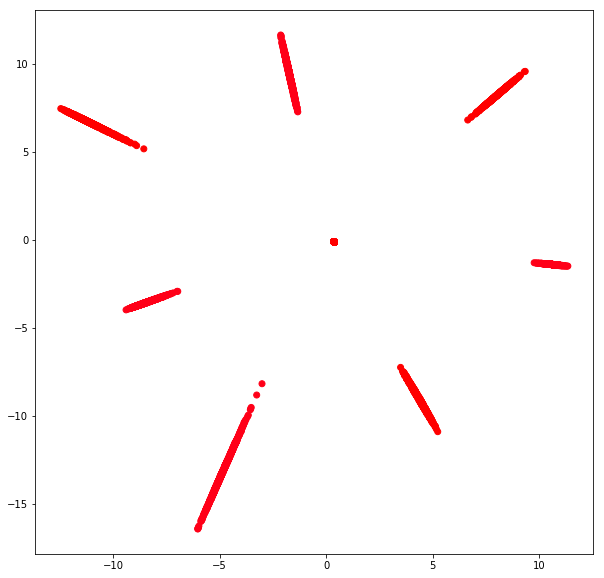

In [18]:
accuracy, data = test(model, dataloader)
plot_dataloader = DataLoader(server_data, batch_size=10, shuffle=True)
Plot.plot_data(2, plot_dataloader, "hsv")